# 特征工程
目标：对数据统计特征进行分析处理  

内容：  
1. 异常处理
2. 归一化/标准化
3. 数据分桶
4. 缺失值处理
5. 特征构造
6. 特征筛选
7. 降维

字面**初步**理解：1/2 实际上是提取数据的一般规律，以备提高模型泛化能力；3/4数据预处理；5/6/7拟合数据

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter
%matplotlib inline

path = './data/'
Train_data = pd.read_csv(path+'used_car_train_20200313.csv', sep=' ')
Test_data = pd.read_csv(path+'used_car_testA_20200313.csv', sep=' ')
print(Train_data.shape)
print(Test_data.shape)

(150000, 31)
(50000, 30)


In [2]:
Train_data.columns, Test_data.columns

(Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
        'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
        'seller', 'offerType', 'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3',
        'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
        'v_13', 'v_14'],
       dtype='object'),
 Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
        'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
        'seller', 'offerType', 'creatDate', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4',
        'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13',
        'v_14'],
       dtype='object'))

## 删除异常值
- 通过箱线图（或 3-Sigma）分析删除异常值；
- BOX-COX 转换（处理有偏分布）；
- 长尾截断；

In [3]:
# 这里我包装了一个异常值处理的代码，可以随便调用。
def outliers_proc(data, col_name, scale=3):
    """
    用于清洗异常值，默认用 box_plot（scale=3）进行清洗
    :param data: 接收 pandas 数据格式
    :param col_name: pandas 列名
    :param scale: 尺度
    :return:
    """

    def box_plot_outliers(data_ser, box_scale):
        """
        利用箱线图去除异常值
        :param data_ser: 接收 pandas.Series 数据格式
        :param box_scale: 箱线图尺度，
        :return:
        """
        iqr = box_scale * (data_ser.quantile(0.75) - data_ser.quantile(0.25))
        val_low = data_ser.quantile(0.25) - iqr
        val_up = data_ser.quantile(0.75) + iqr
        rule_low = (data_ser < val_low)
        rule_up = (data_ser > val_up)
        return (rule_low, rule_up), (val_low, val_up)

    data_n = data.copy()
    data_series = data_n[col_name]
    rule, value = box_plot_outliers(data_series, box_scale=scale)
    index = np.arange(data_series.shape[0])[rule[0] | rule[1]]
    print("Delete number is: {}".format(len(index)))
    data_n = data_n.drop(index)
    data_n.reset_index(drop=True, inplace=True)
    print("Now column number is: {}".format(data_n.shape[0]))
    index_low = np.arange(data_series.shape[0])[rule[0]]
    outliers = data_series.iloc[index_low]
    print("Description of data less than the lower bound is:")
    print(pd.Series(outliers).describe())
    index_up = np.arange(data_series.shape[0])[rule[1]]
    outliers = data_series.iloc[index_up]
    print("Description of data larger than the upper bound is:")
    print(pd.Series(outliers).describe())
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 7))
    sns.boxplot(y=data[col_name], data=data, palette="Set1", ax=ax[0])
    sns.boxplot(y=data_n[col_name], data=data_n, palette="Set1", ax=ax[1])
    return data_n

Delete number is: 963
Now column number is: 149037
Description of data less than the lower bound is:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: power, dtype: float64
Description of data larger than the upper bound is:
count      963.000000
mean       846.836968
std       1929.418081
min        376.000000
25%        400.000000
50%        436.000000
75%        514.000000
max      19312.000000
Name: power, dtype: float64


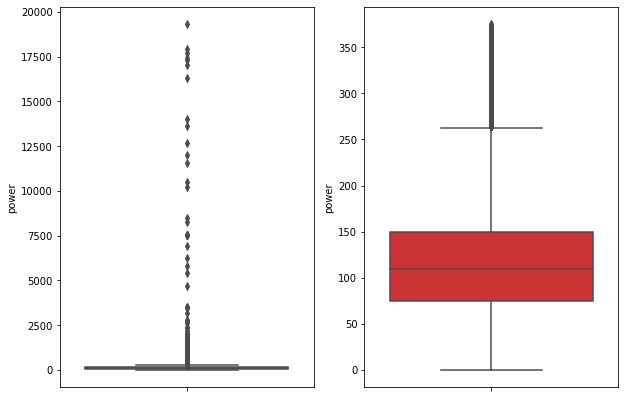

In [4]:
# 我们可以删掉一些异常数据，以 power 为例。  
# 这里删不删同学可以自行判断
# 但是要注意 test 的数据不能删 = = 不能掩耳盗铃是不是

Train_data = outliers_proc(Train_data, 'power', scale=3)

Skewness: 0.555265
Kurtosis: 0.928221


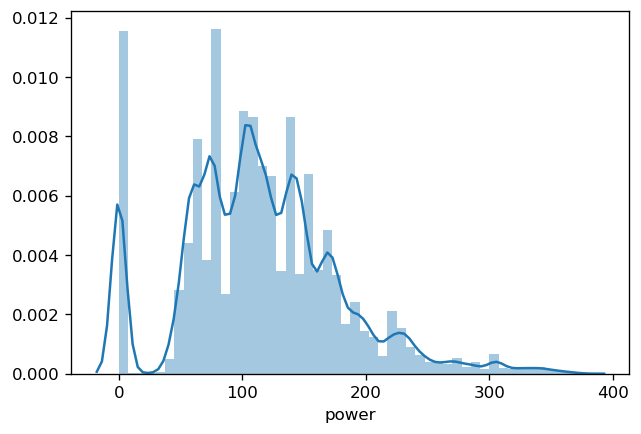

In [5]:
# 查看分布
plt.figure(dpi=120)
sns.distplot(Train_data['power']);
print("Skewness: %f" % Train_data['power'].skew())
print("Kurtosis: %f" % Train_data['power'].kurt())

Skewness: 63.538280
Kurtosis: 5345.533033


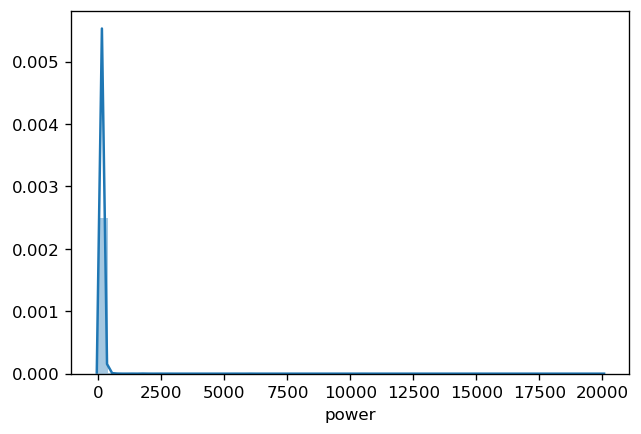

In [6]:
plt.figure(dpi=120)
sns.distplot(Test_data['power']);
print("Skewness: %f" % Test_data['power'].skew())
print("Kurtosis: %f" % Test_data['power'].kurt())

## 数据分桶 + 特征构造
为什么要做数据分桶呢，原因有很多，= =
1. 离散后稀疏向量内积乘法运算速度更快，计算结果也方便存储，容易扩展；
2. 离散后的特征对异常值更具鲁棒性，如 age>30 为 1 否则为 0，对于年龄为 200 的也不会对模型造成很大的干扰；
3. LR 属于广义线性模型，表达能力有限，经过离散化后，每个变量有单独的权重，这相当于引入了非线性，能够提升模型的表达能力，加大拟合；
4. 离散后特征可以进行特征交叉，提升表达能力，由 M+N 个变量编程 M*N 个变量，进一步引入非线形，提升了表达能力；
5. 特征离散后模型更稳定，如用户年龄区间，不会因为用户年龄长了一岁就变化
当然还有很多原因，LightGBM 在改进 XGBoost 时就增加了数据分桶，增强了模型的泛化性

In [7]:
# 训练集和测试集放在一起，方便构造特征
Train_data['train']=1
Test_data['train']=0
data = pd.concat([Train_data, Test_data], ignore_index=True)

# 使用时间：data['creatDate'] - data['regDate']，反应汽车使用时间，一般来说价格与使用时间成反比
# 不过要注意，数据里有时间出错的格式，所以我们需要 errors='coerce'
data['used_time'] = (pd.to_datetime(data['creatDate'], format='%Y%m%d', errors='coerce') - 
                            pd.to_datetime(data['regDate'], format='%Y%m%d', errors='coerce')).dt.days

# 看一下空数据，有 15k 个样本的时间是有问题的，我们可以选择删除，也可以选择放着。
# 但是这里不建议删除，因为删除缺失数据占总样本量过大，7.5%
# 我们可以先放着，因为如果我们 XGBoost 之类的决策树，其本身就能处理缺失值，所以可以不用管；
print("null in used_time", data['used_time'].isnull().sum())

# 从邮编中提取城市信息，相当于加入了先验知识
data['city'] = data['regionCode'].apply(lambda x : str(x)[:-3])
data = data

# 计算某品牌的销售统计量，同学们还可以计算其他特征的统计量
# 这里要以 train 的数据计算统计量
Train_gb = Train_data.groupby("brand")
all_info = {}
for kind, kind_data in Train_gb:
    info = {}
    kind_data = kind_data[kind_data['price'] > 0]
    info['brand_amount'] = len(kind_data)
    info['brand_price_max'] = kind_data.price.max()
    info['brand_price_median'] = kind_data.price.median()
    info['brand_price_min'] = kind_data.price.min()
    info['brand_price_sum'] = kind_data.price.sum()
    info['brand_price_std'] = kind_data.price.std()
    info['brand_price_average'] = round(kind_data.price.sum() / (len(kind_data) + 1), 2)
    all_info[kind] = info
brand_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": "brand"})
data = data.merge(brand_fe, how='left', on='brand')

# 删除不需要的数据
data = data.drop(['creatDate', 'regDate', 'regionCode'], axis=1)

# 数据分桶 以 power 为例
# 这时候我们的缺失值也进桶了，
bin = [i*10 for i in range(31)]
data['power_bin'] = pd.cut(data['power'], bin, labels=False)
print(data.shape)
print(data.columns)
data[['power_bin', 'power']].head()

c:\software\anaconda3\envs\new\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


null in used_time 15072
(199037, 39)
Index(['SaleID', 'bodyType', 'brand', 'fuelType', 'gearbox', 'kilometer',
       'model', 'name', 'notRepairedDamage', 'offerType', 'power', 'price',
       'seller', 'train', 'v_0', 'v_1', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14',
       'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'used_time',
       'city', 'brand_amount', 'brand_price_max', 'brand_price_median',
       'brand_price_min', 'brand_price_sum', 'brand_price_std',
       'brand_price_average', 'power_bin'],
      dtype='object')


,power_bin,power
0,5.0,60
1,NaN,0
2,16.0,163
3,19.0,193
4,6.0,68


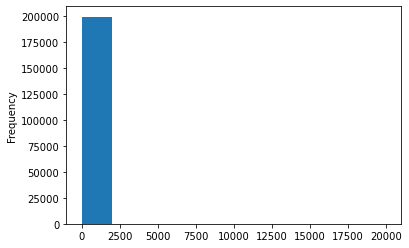

In [8]:
# 目前的数据其实已经可以给树模型使用了，所以我们导出一下
data.to_csv('data_for_tree.csv', index=0)

# 我们可以再构造一份特征给 LR NN 之类的模型用
# 之所以分开构造是因为，不同模型对数据集的要求不同
# 看下数据分布：
data['power'].plot.hist()

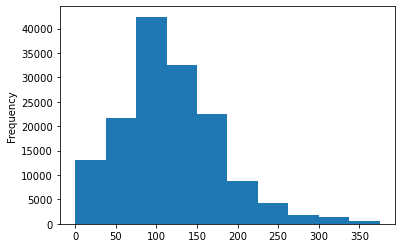

In [9]:
# 刚刚已经对 train 进行异常值处理了，但是现在还有这么奇怪的分布是因为 test 中的 power 异常值，
# 所以之前 train 中的 power 异常值不删为好，可以用长尾分布截断来代替
Train_data['power'].plot.hist()

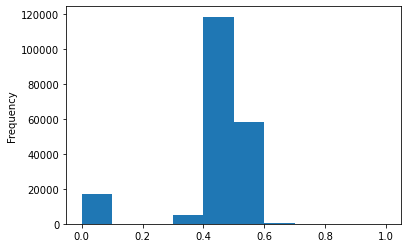

In [10]:
# 对其取 log，再做归一化
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data['power'] = np.log(data['power'] + 1) 
data['power'] = ((data['power'] - np.min(data['power'])) / (np.max(data['power']) - np.min(data['power'])))
data['power'].plot.hist()

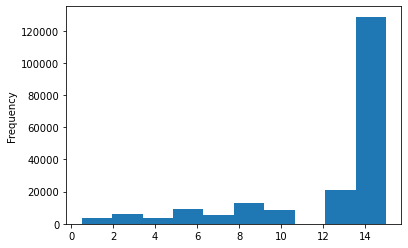

In [11]:
# km 的比较正常，应该是已经做过分桶了
data['kilometer'].plot.hist()

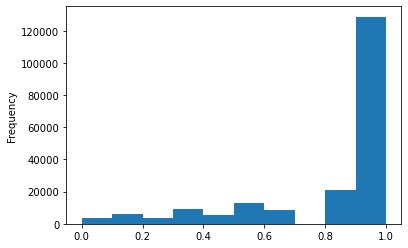

In [12]:
# 直接做归一化
data['kilometer'] = ((data['kilometer'] - np.min(data['kilometer'])) / 
                        (np.max(data['kilometer']) - np.min(data['kilometer'])))
data['kilometer'].plot.hist()

In [13]:
# 除此之外 还有刚刚构造的统计量特征：
# 'brand_amount', 'brand_price_average', 'brand_price_max',
# 'brand_price_median', 'brand_price_min', 'brand_price_std',
# 'brand_price_sum'
# 直接做变换，
def max_min(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

data['brand_amount'] = ((data['brand_amount'] - np.min(data['brand_amount'])) / 
                        (np.max(data['brand_amount']) - np.min(data['brand_amount'])))
data['brand_price_average'] = ((data['brand_price_average'] - np.min(data['brand_price_average'])) / 
                               (np.max(data['brand_price_average']) - np.min(data['brand_price_average'])))
data['brand_price_max'] = ((data['brand_price_max'] - np.min(data['brand_price_max'])) / 
                           (np.max(data['brand_price_max']) - np.min(data['brand_price_max'])))
data['brand_price_median'] = ((data['brand_price_median'] - np.min(data['brand_price_median'])) /
                              (np.max(data['brand_price_median']) - np.min(data['brand_price_median'])))
data['brand_price_min'] = ((data['brand_price_min'] - np.min(data['brand_price_min'])) / 
                           (np.max(data['brand_price_min']) - np.min(data['brand_price_min'])))
data['brand_price_std'] = ((data['brand_price_std'] - np.min(data['brand_price_std'])) / 
                           (np.max(data['brand_price_std']) - np.min(data['brand_price_std'])))
data['brand_price_sum'] = ((data['brand_price_sum'] - np.min(data['brand_price_sum'])) / 
                           (np.max(data['brand_price_sum']) - np.min(data['brand_price_sum'])))

In [16]:
# 对类别特征进行 OneEncoder
data = pd.get_dummies(data, columns=['model', 'brand', 'bodyType', 'fuelType',
                                     'gearbox', 'notRepairedDamage', 'power_bin'])

print(data.shape)
print(data.columns)
# 这份数据可以给 LR 用
data.to_csv('data_for_lr.csv', index=0)

(199037, 370)
Index(['SaleID', 'kilometer', 'name', 'offerType', 'power', 'price', 'seller',
       'train', 'v_0', 'v_1',
       ...
       'power_bin_20.0', 'power_bin_21.0', 'power_bin_22.0', 'power_bin_23.0',
       'power_bin_24.0', 'power_bin_25.0', 'power_bin_26.0', 'power_bin_27.0',
       'power_bin_28.0', 'power_bin_29.0'],
      dtype='object', length=370)


## 特征筛选

### 过滤

0.5728285196051496
-0.4082569701616764
0.058156610025581514
0.3834909576057687
0.259066833880992
0.38691042393409447


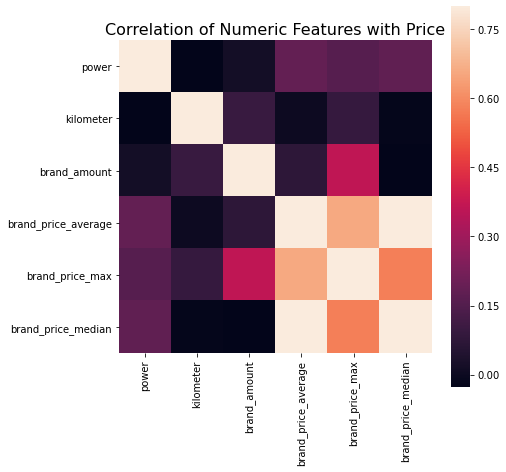

In [17]:
# 相关性分析
print(data['power'].corr(data['price'], method='spearman'))
print(data['kilometer'].corr(data['price'], method='spearman'))
print(data['brand_amount'].corr(data['price'], method='spearman'))
print(data['brand_price_average'].corr(data['price'], method='spearman'))
print(data['brand_price_max'].corr(data['price'], method='spearman'))
print(data['brand_price_median'].corr(data['price'], method='spearman'))

# 直接看图
data_numeric = data[['power', 'kilometer', 'brand_amount', 'brand_price_average', 
                     'brand_price_max', 'brand_price_median']]
correlation = data_numeric.corr()

f , ax = plt.subplots(figsize = (7, 7))
plt.title('Correlation of Numeric Features with Price',y=1,size=16)
sns.heatmap(correlation,square = True,  vmax=0.8)

### 包裹

In [18]:
# k_feature 太大会很难跑，没服务器，所以提前 interrupt 了
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
sfs = SFS(LinearRegression(),
           k_features=10,
           forward=True,
           floating=False,
           scoring = 'r2',
           cv = 0)
x = data.drop(['price'], axis=1)
x = x.fillna(0)
y = data['price']
sfs.fit(x, y)
print(sfs.k_feature_names_ )

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [22]:
nas = data.isna().sum()
nas[nas > 0]

price        50000
used_time    15072
dtype: int64

In [25]:
data['used_time']

0         4385.0
1         4757.0
2         4382.0
3         7125.0
4         1531.0
           ...  
199032    7261.0
199033    6014.0
199034    4345.0
199035       NaN
199036    4151.0
Name: used_time, Length: 199037, dtype: float64

In [27]:
nas = x.isna().sum()
nas[nas > 0]

Series([], dtype: int64)

In [30]:
# there are NaN in y
y = y.fillna(0)
sfs.fit(x, y)
print(sfs.k_feature_names_ )

ValueError: could not convert string to float: 

In [ ]:
# 画出来，可以看到边际效益
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.grid()
plt.show()